In [43]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pywt

## **Transformation** dans un autre domaine

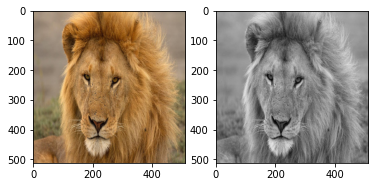

In [44]:
# Chargement de l'image
filename = './figures/06.png'
IMAGE_bgr = cv2.imread(filename)
IMAGE_rgb = cv2.cvtColor(IMAGE_bgr, cv2.COLOR_BGR2RGB)
IMAGE_nb = cv2.cvtColor(IMAGE_rgb, cv2.COLOR_RGB2GRAY)
[H,W] = IMAGE_nb.shape
plt.subplot(121)
plt.imshow(IMAGE_rgb)
plt.subplot(122)
plt.imshow(IMAGE_nb, cmap='gray')
plt.show()

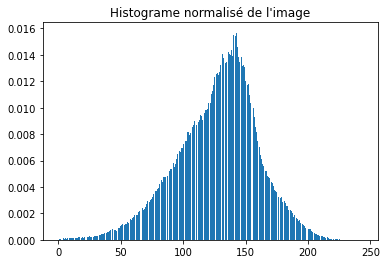

In [45]:
hist_IMAGE_nb, bin_edges_IMAGE_nb = np.histogram(IMAGE_nb, bins=255)
bin_edges_IMAGE_nb = bin_edges_IMAGE_nb[:-1:]
hist_IMAGE_nb_normalise = hist_IMAGE_nb / (H*W) 
plt.bar(bin_edges_IMAGE_nb, hist_IMAGE_nb_normalise)
plt.title('Histograme normalisé de l\'image')
plt.show()
# plt.plot(bin_edges_IMAGE_nb, hist_IMAGE_nb)


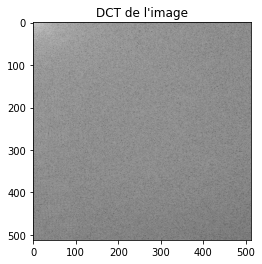

In [46]:
# Transformation - DCT - Dicrete Cosinus Transform
IMAGE_DCT = cv2.dct(IMAGE_nb.astype(float))

plt.imshow(np.log(np.abs(IMAGE_DCT)), 'gray')
plt.title('DCT de l\'image' )
plt.show()

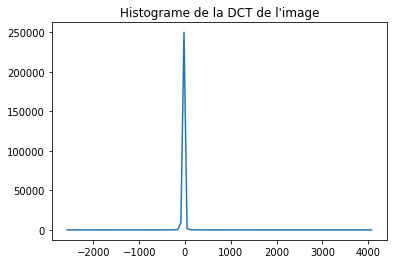

In [47]:
# hist_IMAGE_DCT, bin_edges_IMAGE_DCT = np.histogram(IMAGE_DCT, bins=1000)

IMAGE_DCT_sansMin = np.copy(IMAGE_DCT)
IMAGE_DCT_sansMin[0][0] = 0
hist_IMAGE_DCT, bin_edges_IMAGE_DCT = np.histogram(IMAGE_DCT_sansMin, bins=100)

bin_edges_IMAGE_DCT = bin_edges_IMAGE_DCT[:-1:]
plt.plot(bin_edges_IMAGE_DCT, hist_IMAGE_DCT)
plt.title('Histograme de la DCT de l\'image')
plt.show()

## **Codage** et **quantification** des coefficients

In [48]:
# Decoupage de l'image
listImages88 = list()
I,J = 0,0
for i in range(W//8):
    for j in range(H//8):
        # imagette = IMAGE_nb[J:J+8, I:I+8]
        imagette = IMAGE_nb[i*8:(i+1)*8 , j*8:(j+1)*8]
        listImages88.append(imagette)
        J+=j*8
    I+=i*8


In [49]:
# Calcul DCT par bloc 
listImages88DCT = list()
for imagette in listImages88:
    foo = cv2.dct(imagette.astype(float))
    listImages88DCT.append( foo )
    

### **Quantification**

In [50]:
Z = [[16, 11, 10, 16, 24,  40,  51,  61],
     [12, 12, 14, 19, 26,  58,  60,  55],
     [14, 13, 16, 24, 40,  57,  69,  56],
     [14, 17, 22, 29, 51,  87,  80,  62],
     [18, 22, 37, 56, 68,  109, 103, 77],
     [24, 35, 55, 64, 81,  104, 113, 92],
     [49, 64, 78, 87, 103, 121, 120, 101],
     [72, 92, 95, 98, 112, 100, 103, 99]]
Z = np.array(Z)
T_hat = list()
T_hat_posNonNul = list()

for T in listImages88DCT:
     tmp = (T/Z).round().astype(int)
     T_hat.append( tmp )
     position = np.where(np.abs(tmp)>0,1,0)
     T_hat_posNonNul.append(position)



### **Codage**

In [51]:
def zigzag(a):
    # returnList = list()
    returnList = np.concatenate( [np.diagonal(a[::-1,:], i)[::(2*(i % 2)-1)] for i in range(1-a.shape[0], a.shape[0]) ] )
    return returnList

In [118]:
# Parcours en zigzag de chaque DFT 8x8
CODE_values = list()
CODE_position = list()
for (imagette,position) in zip(T_hat,T_hat_posNonNul):
    codeBloc = zigzag(imagette)  
    codePosition = zigzag(position) 
    codePosition2 = ''.join(map(str, codePosition))
    # print(codePosition2)
    CODE_values.append(codeBloc) 
    CODE_position.append(codePosition2)


In [53]:
def run_length_encode(input_str):
    run_length_encoded_string = []
    current_run_length = 1
    # Perform a run length encoding of input_str
    for i in range(1, len(input_str)):
        current_char = input_str[i]
        previous_char = input_str[i-1]
        if current_char != previous_char or current_run_length == 9:
            run_length_encoded_string.append(str(current_run_length))
            run_length_encoded_string.append(previous_char)
            current_run_length = 0
        current_run_length += 1
    # Handle any remaining character
    run_length_encoded_string.append(str(current_run_length))
    run_length_encoded_string.append(input_str[len(input_str)-1])
    return "".join(run_length_encoded_string)

In [54]:
# codage par plage pour enchainer les positions non nulles 
CODE_position_parPlage = list()
for position in CODE_position:
    codageParPlage = run_length_encode(position)
    CODE_position_parPlage.append(codageParPlage)
    # print(position)
    # print(codageParPlage)

In [55]:
def toBinary4bit(nb):
    if type(nb) != int:
        print('INVALID VARIABLE TYPE')
        return False
    else : 
        if nb < 0 or nb > 9:
            print('INVALID NUMBER')
            return False
        if nb >= 0 and nb <= 9 :
            binary = bin(nb)
            binary = binary[2::]
            binary = binary.zfill(4)
            return binary

In [56]:
def codageBinaireDuCodeParPlage(str):
    BINARY = ''
    for char in str:
        foo = toBinary4bit(int(char))
        BINARY += foo
    return BINARY

In [57]:
tmp = CODE_position_parPlage[0]
print(tmp)
BIN = codageBinaireDuCodeParPlage(tmp)
print(BIN)

3190909090909070
0011000110010000100100001001000010010000100100001001000001110000


In [62]:
flagBLOC = 'B'
flagVAL = 'V'
flagVAL2POS = 'P'

def codageBLOC(arrValues, strPosition):
    flagBLOC = 'B'
    flagVAL = 'V'
    flagVAL2POS = 'P'
    total_code = ''

    values = arrValues[arrValues!=0]
    strValues = flagVAL.join(values.astype(str))
    # print(strValues)
    total_code += strValues
    total_code += flagVAL2POS
    total_code += strPosition
    total_code += flagBLOC
    # print(total_code)
    return total_code

# tmp = codageBLOC(T_hat[0], CODE_position_parPlage[0])
# print(tmp)

In [63]:
test = ''
for i in range(0,5):
    foo = codageBLOC(T_hat[i], CODE_position_parPlage[i])
    # print(foo)
    test += foo

with open('compressed.txt', 'w') as file:
    for (arrValues, strPosition) in zip(T_hat, CODE_position_parPlage):
        bloc = codageBLOC(arrValues, strPosition)
        file.write(bloc)

## **Décodage** et **décompression** de l'image

#### processus inverse :
- lire fichier 
- ecire fichier dans str
- split par bloc
- split valeurs et position
- split valeurs
- décoder zigzag
- créer image T_hat 
- opération avec Z 
- concat de toutes les imagettes 

In [66]:
with open('compressed.txt', 'r') as file:
    stringTot = file.read()
listBloc = stringTot.split(flagBLOC)

In [107]:
def decodeBLOC(strBLOC):
    listBloc.pop()
    bloc_tmp = listBloc[0]
    tmp = bloc_tmp.split(flagVAL2POS)
    values = tmp[0]
    pos = tmp[1]
    values = values.split(flagVAL)
    return values, pos

In [110]:
def decodeCodeParPlage(str):
    arrPosNonNulles = []
    for i in range(0,len(str), 2):
        for k in range(0,int(str[i])):
            arrPosNonNulles.append( int(str[i+1]) )        
    return np.array(arrPosNonNulles)

In [123]:
def decodeZZ(arrZZ):
    imagette = np.zeros((8,8))
    for k in range(len(arrZZ)):
        pass
    plt.imshow(imagette)

[74  1 -1]
[1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


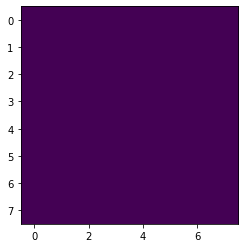

In [124]:
values_tmp, pos_tmp = decodeBLOC(listBloc[0])
values_tmp = np.array(values_tmp)
values_tmp = values_tmp.astype(int)
pos_tmp = decodeCodeParPlage(pos_tmp)
print(values_tmp)
print(pos_tmp)

decodeZZ(pos_tmp)

In [ ]:
# print(test)
# flagBLOC = 'B'
# blocs = test.split(flagBLOC)
# blocs.pop()
# print(blocs)